# Classifying Fashion-MNIST

Now it's your turn to build and train a neural network. You'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world.

<img src='assets/fashion-mnist-sprite.png' width=500px>

In this notebook, you'll build your own neural network. For the most part, you could just copy and paste the code from Part 3, but you wouldn't be learning. It's important for you to write the code yourself and get it to work. Feel free to consult the previous notebooks though as you work through this.

First off, let's load the dataset through torchvision.

In [1]:
import torch
from torchvision import datasets, transforms
import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting C:\Users\Creator/.pytorch/F_MNIST_data/FashionMNIST\raw\train-images-idx3-ubyte.gz to C:\Users\Creator/.pytorch/F_MNIST_data/FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting C:\Users\Creator/.pytorch/F_MNIST_data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\Creator/.pytorch/F_MNIST_data/FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting C:\Users\Creator/.pytorch/F_MNIST_data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\Creator/.pytorch/F_MNIST_data/FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting C:\Users\Creator/.pytorch/F_MNIST_data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\Creator/.pytorch/F_MNIST_data/FashionMNIST\raw



Here we can see one of the images.

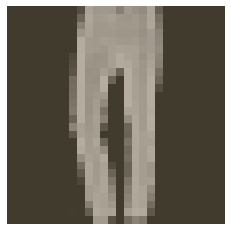

In [5]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

## Building the network

Here you should define your network. As with MNIST, each image is 28x28 which is a total of 784 pixels, and there are 10 classes. You should include at least one hidden layer. We suggest you use ReLU activations for the layers and to return the logits or log-softmax from the forward pass. It's up to you how many layers you add and the size of those layers.

In [65]:
import torch
from torch import nn
import torch.nn.functional as F

n_input = 28 * 28
n_output = 10

model = nn.Sequential(
    nn.Linear(n_input, 256),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(64, n_output),
    nn.LogSoftmax(dim=1),
)
model

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=64, out_features=10, bias=True)
  (10): LogSoftmax(dim=1)
)

# Train the network

Now you should create your network and train it. First you'll want to define [the criterion](http://pytorch.org/docs/master/nn.html#loss-functions) ( something like `nn.CrossEntropyLoss`) and [the optimizer](http://pytorch.org/docs/master/optim.html) (typically `optim.SGD` or `optim.Adam`).

Then write the training code. Remember the training pass is a fairly straightforward process:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

By adjusting the hyperparameters (hidden units, learning rate, etc), you should be able to get the training loss below 0.4.

In [70]:
learnrate = 0.001
epochs = 10

In [75]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()
model.apply(weight_reset)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=64, out_features=10, bias=True)
  (10): LogSoftmax(dim=1)
)

In [76]:
from torch import optim

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.parameters(), lr=learnrate)

In [77]:
def validate_model(testloader, model):
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for images, labels in testloader:
            flat_images = images.view(images.shape[0], -1)

            output = model(flat_images)
            loss = criterion(output, labels)

            validation_loss += loss.item()
    model.train()
    return validation_loss / len(testloader)

In [78]:
training_losses = []
validation_losses = []
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        flat_images = images.view(images.shape[0], -1)
        
        optimizer.zero_grad()
        output = model(flat_images)
        loss = criterion(output, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()

    training_loss = running_loss / len(trainloader)
    validation_loss = validate_model(testloader, model)
    training_losses.append(training_loss)
    validation_losses.append(validation_loss)
    print(f"\rTraining Loss: {round(training_loss, 3)}, Validation Loss: {round(validation_loss, 3)}")

Training Loss: 0.594, Validation Loss: 0.442
Training Loss: 0.433, Validation Loss: 0.406
Training Loss: 0.395, Validation Loss: 0.386
Training Loss: 0.371, Validation Loss: 0.381
Training Loss: 0.353, Validation Loss: 0.373
Training Loss: 0.342, Validation Loss: 0.355
Training Loss: 0.326, Validation Loss: 0.36
Training Loss: 0.319, Validation Loss: 0.347
Training Loss: 0.315, Validation Loss: 0.345
Training Loss: 0.305, Validation Loss: 0.355


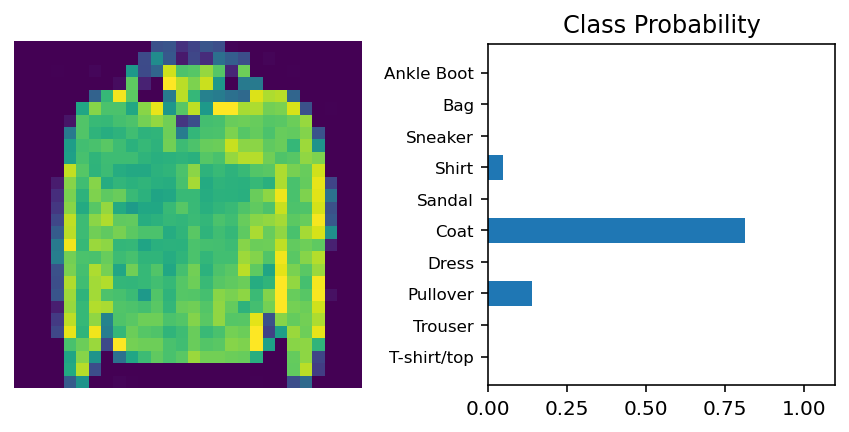

In [79]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper

# Test out your network!

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

with torch.no_grad():
    logps = model(img)
ps = torch.exp(logps)

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps, version='Fashion')

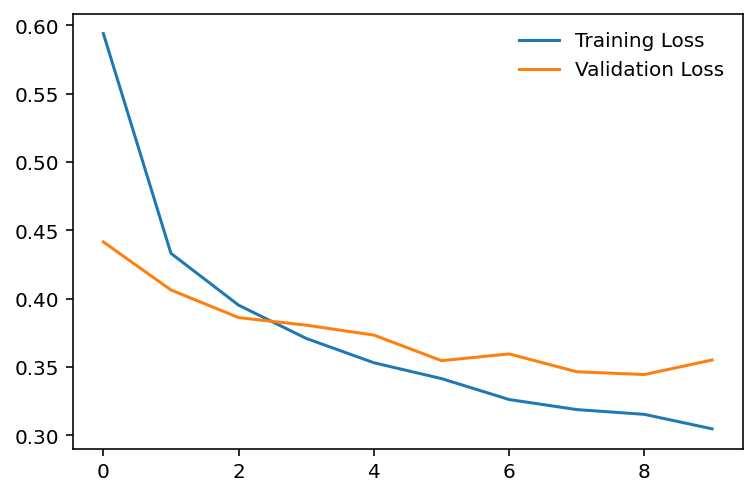

In [80]:
import matplotlib.pyplot as plt

plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.legend(frameon=False)